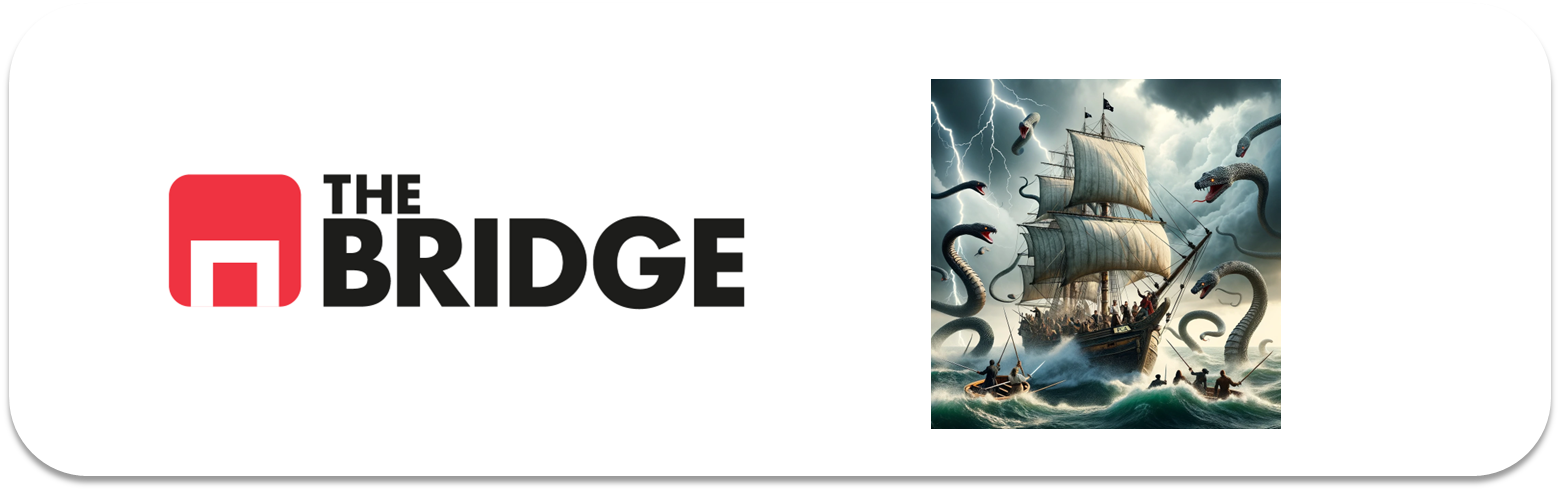

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE, SequentialFeatureSelector, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [17]:
df = pd.read_csv("./data/credit_npo.csv")

In [18]:
df.head(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [20]:
# Eliminar filas con valores nulos
df.dropna(inplace=True)

In [21]:
# Convertir variables "NumberOf..." a categóricas con 2-3 niveles
categorical_features = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']
for col in categorical_features:
    df[col] = pd.cut(df[col], bins=[-1, 0, 2, np.inf], labels=['0', '1', '2'])

In [22]:
# Separar features y target
target = "SeriousDlqin2yrs"
X = df.drop(columns=[target])
y = df[target]

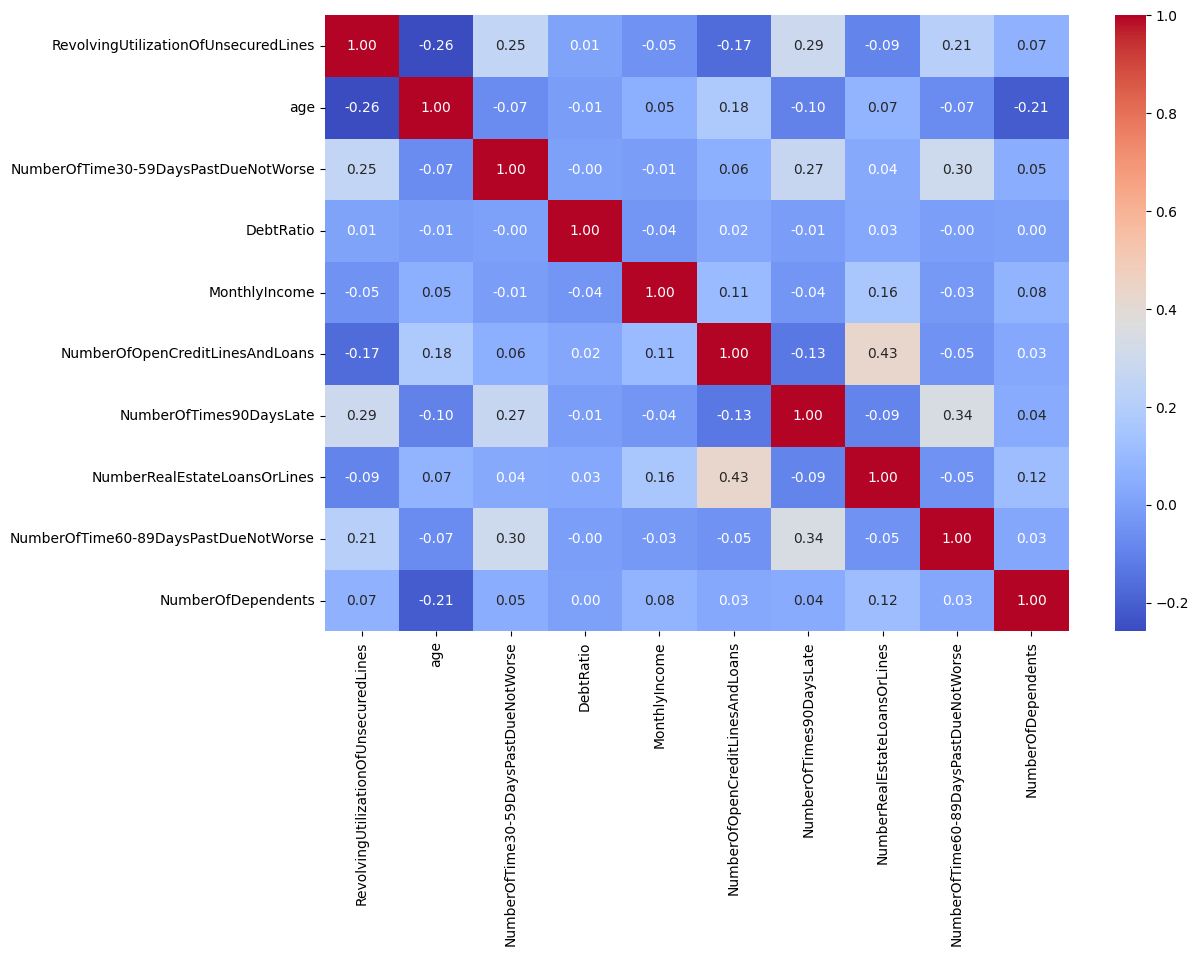

In [23]:
### Ejercicio 2: Análisis y Selección de Features

# 2.1 Análisis visual + filtrado por correlación y covarianza
corr_matrix = X.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

variance_filter = VarianceThreshold(threshold=0.1)
X_var_filtered = variance_filter.fit_transform(X)

In [24]:
# 2.2 SelectKBest y ANOVA
selector_kbest = SelectKBest(score_func=f_classif, k=6)
X_kbest = selector_kbest.fit_transform(X, y)

In [25]:
# 2.3 Mutual Information para categóricas
mi_scores = mutual_info_classif(X[categorical_features], y)
mi_features = [categorical_features[i] for i in range(len(mi_scores)) if mi_scores[i] > 0.01]

In [26]:
# 2.4 Selección con SelectFromModel
rf = RandomForestClassifier()
selector_model = SelectFromModel(rf, threshold='median')
selector_model.fit(X, y)
X_model_selected = selector_model.transform(X)

In [27]:
# 2.5 Selección con RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=6)
rfe.fit(X, y)
X_rfe_selected = rfe.transform(X)

In [28]:
# 2.6 Selección con SFS
sfs = SequentialFeatureSelector(RandomForestClassifier(), n_features_to_select=6, direction='forward')
sfs.fit(X, y)
X_sfs_selected = sfs.transform(X)

In [29]:
# 2.7 Hard-Voting entre las selecciones anteriores
selected_features = list(set(X.columns[selector_kbest.get_support()]) | set(mi_features) | set(selector_model.get_feature_names_out()) | set(rfe.get_feature_names_out()) | set(sfs.get_feature_names_out()))
X_voting = X[selected_features]

In [30]:
### Ejercicio 3: Comparación de Modelos
models = {
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
    'GradientBoosting': GradientBoostingClassifier()
}

In [31]:
for model_name, model in models.items():
    for X_set, set_name in zip([X_kbest, X_model_selected, X_rfe_selected, X_sfs_selected, X_voting], ['KBest', 'Model', 'RFE', 'SFS', 'Voting']):
        scores = cross_val_score(model, X_set, y, cv=5, scoring='recall')
        print(f"{model_name} con {set_name}: Recall medio: {np.mean(scores):.4f}")

RandomForest con KBest: Recall medio: 0.1928
RandomForest con Model: Recall medio: 0.1940
RandomForest con RFE: Recall medio: 0.1928
RandomForest con SFS: Recall medio: 0.2133
RandomForest con Voting: Recall medio: 0.1831
LogisticRegression con KBest: Recall medio: 0.1747


c:\Users\María Moya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\María Moya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

LogisticRegression con Model: Recall medio: 0.1482


c:\Users\María Moya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\María Moya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

LogisticRegression con RFE: Recall medio: 0.1639
LogisticRegression con SFS: Recall medio: 0.1783


c:\Users\María Moya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\María Moya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\María Moya\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
        cac

LogisticRegression con Voting: Recall medio: nan
GradientBoosting con KBest: Recall medio: 0.1711
GradientBoosting con Model: Recall medio: 0.1542
GradientBoosting con RFE: Recall medio: 0.1554
GradientBoosting con SFS: Recall medio: 0.1554
GradientBoosting con Voting: Recall medio: 0.1964


In [32]:
### Ejercicio 4: Optimización y Evaluación Final

from sklearn.model_selection import GridSearchCV

best_model = RandomForestClassifier()
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_voting, y)
print("Mejor configuración:", grid_search.best_params_)

Mejor configuración: {'max_depth': None, 'n_estimators': 100}


### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.

In [33]:
### EXTRA: PCA
pca = PCA(n_components=0.95)  # Selección basada en varianza explicada
X_pca = pca.fit_transform(X)
final_model = RandomForestClassifier()
final_model.fit(X_pca, y)
scores = cross_val_score(final_model, X_pca, y, cv=5, scoring='recall')
print("Modelo con PCA: Recall medio:", np.mean(scores))

Modelo con PCA: Recall medio: 0.06385542168674699
